# Option Pricing & Simulation Notebook

This notebook contains:
1. Brownian motion simulation  
2. Distribution of \(S_T\) and histogram  
3. Analytic Black–Scholes pricing and a 3D price surface vs strike \(K\) and maturity \(T\)  
4. Simulated asset price trajectories  
5. Monte-Carlo pricing of Asian (arithmetic average) and barrier options using simulated trajectories

All plots use `matplotlib` (no seaborn). Adjust parameters in the "Parameters" cell.

In [1]:
# Parameters (change these to experiment)
import numpy as np

S0 = 100.0        # initial stock price
r = 0.03          # risk-free rate (annual)
sigma = 0.25      # volatility (annual)
T = 1.0           # maturity in years (default for parts)
seed = 42
np.random.seed(seed)

# Simulation settings
n_paths = 20000   # number of Monte-Carlo paths
n_steps = 252     # steps per path for trajectories (daily)
dt = T / n_steps

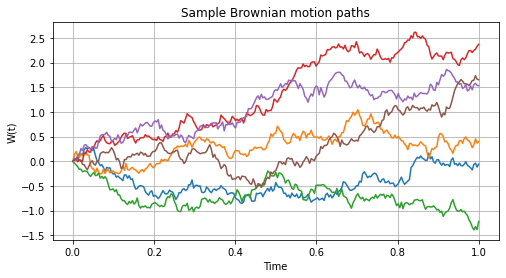

In [2]:
# 1) Brownian motion simulation
import numpy as np
import matplotlib.pyplot as plt

n = n_steps
dt = T / n
t = np.linspace(0, T, n+1)

# simulate a few Brownian motion paths
def simulate_brownian(n_paths_plot=6):
    dW = np.sqrt(dt) * np.random.randn(n_paths_plot, n)
    W = np.cumsum(dW, axis=1)
    W = np.hstack((np.zeros((n_paths_plot,1)), W))
    return t, W

t, W = simulate_brownian(6)

plt.figure(figsize=(8,4))
for i in range(W.shape[0]):
    plt.plot(t, W[i])
plt.title('Sample Brownian motion paths')
plt.xlabel('Time')
plt.ylabel('W(t)')
plt.grid(True)
plt.show()

/Users/miller/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


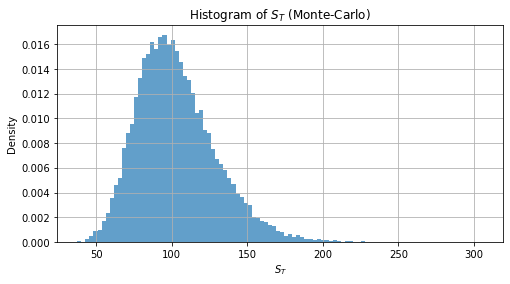

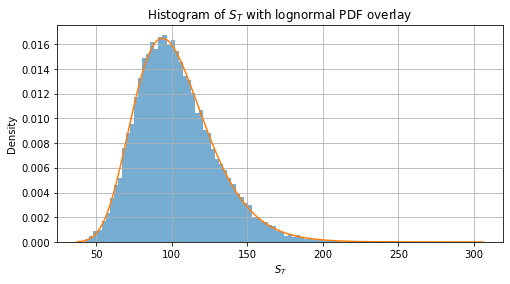

In [3]:
# 2) Law of S_T and histogram of its distribution
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Analytical distribution: under Black-Scholes, S_T is lognormal
def simulate_S_T_mc(S0, r, sigma, T, n_paths):
    Z = np.random.randn(n_paths)
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    return ST

ST = simulate_S_T_mc(S0, r, sigma, T, n_paths)

# Histogram
plt.figure(figsize=(8,4))
plt.hist(ST, bins=100, density=True, alpha=0.7)
plt.title('Histogram of $S_T$ (Monte-Carlo)')
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Overlay analytical lognormal pdf
mu_ln = np.log(S0) + (r - 0.5*sigma**2)*T
sigma_ln = sigma*np.sqrt(T)
x = np.linspace(min(ST), max(ST), 200)
pdf = lognorm.pdf(x, s=sigma_ln, scale=np.exp(mu_ln))
plt.figure(figsize=(8,4))
plt.hist(ST, bins=100, density=True, alpha=0.6)
plt.plot(x, pdf)
plt.title('Histogram of $S_T$ with lognormal PDF overlay')
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.grid(True)
plt.show()

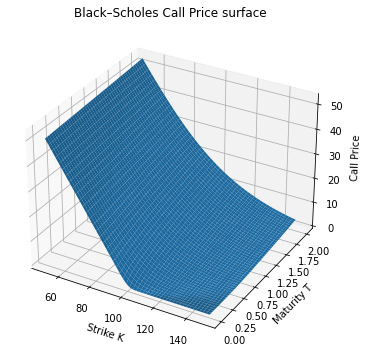

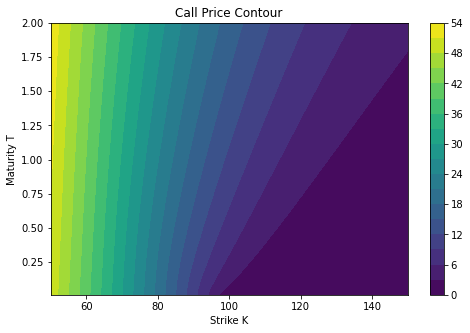

In [4]:
# 3) Black-Scholes analytic pricing and 3D price surface vs K and T
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

def bs_call_price(S, K, T, r, sigma):
    # handle T==0
    if T <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S / K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# Create grid for K and T
Ks = np.linspace(50, 150, 50)
Ts = np.linspace(0.01, 2.0, 50)  # avoid zero to prevent division by zero
KK, TT = np.meshgrid(Ks, Ts)

price_grid = np.vectorize(bs_call_price)(S0, KK, TT, r, sigma)

# 3D surface plot
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(KK, TT, price_grid, linewidth=0, antialiased=True)
ax.set_xlabel('Strike K')
ax.set_ylabel('Maturity T')
ax.set_zlabel('Call Price')
ax.set_title('Black–Scholes Call Price surface')
plt.show()

# Contour plot (2D) for another view
plt.figure(figsize=(8,5))
cs = plt.contourf(KK, TT, price_grid, levels=20)
plt.colorbar(cs)
plt.xlabel('Strike K')
plt.ylabel('Maturity T')
plt.title('Call Price Contour')
plt.show()

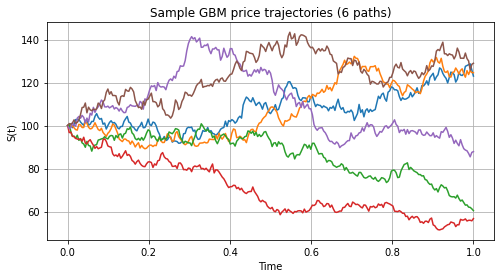

In [5]:
# 4) Simulate S trajectories (geometric Brownian motion)
import numpy as np
import matplotlib.pyplot as plt

def simulate_GBM(S0, r, sigma, T, n_steps, n_paths):
    dt = T / n_steps
    t = np.linspace(0, T, n_steps+1)
    increments = np.random.randn(n_paths, n_steps)
    increments = (r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*increments
    logS = np.cumsum(np.hstack((np.log(S0)*np.ones((n_paths,1)), increments)), axis=1)
    S = np.exp(logS)
    return t, S

t, S_paths = simulate_GBM(S0, r, sigma, T, n_steps, 6)

plt.figure(figsize=(8,4))
for i in range(S_paths.shape[0]):
    plt.plot(t, S_paths[i])
plt.title('Sample GBM price trajectories (6 paths)')
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.grid(True)
plt.show()

Monte-Carlo settings: n_paths = 50000 , n_steps = 252
Asian arithmetic average call price (MC): 6.335758 ± 0.084220 (95% CI)
Up-and-out call price (MC) with barrier H=130: 2.412704 ± 0.048382 (95% CI)


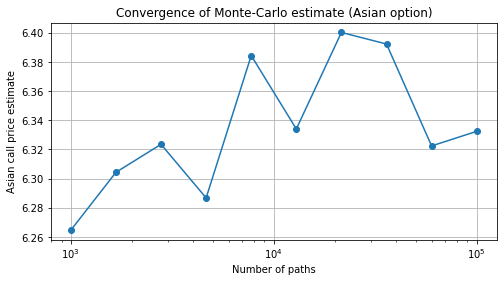

In [6]:
# 5) Asian (arithmetic average) and Barrier option pricing via Monte-Carlo
import numpy as np
import matplotlib.pyplot as plt

def price_asian_arithmetic_mc(S0, K, r, sigma, T, n_steps, n_paths, option_type='call'):
    dt = T / n_steps
    increments = np.random.randn(n_paths, n_steps)
    drift = (r - 0.5*sigma**2)*dt
    diffusion = sigma*np.sqrt(dt)*increments
    log_returns = drift + diffusion
    logS = np.cumsum(np.hstack((np.log(S0)*np.ones((n_paths,1)), log_returns)), axis=1)
    S = np.exp(logS)  # shape (n_paths, n_steps+1)
    # arithmetic average - exclude S0 or include? we'll average over monitoring times excluding initial or include; here include all times
    averages = S.mean(axis=1)
    if option_type == 'call':
        payoffs = np.maximum(averages - K, 0)
    else:
        payoffs = np.maximum(K - averages, 0)
    price = np.exp(-r*T) * payoffs.mean()
    se = np.exp(-r*T) * payoffs.std(ddof=1) / np.sqrt(n_paths)
    return price, se

def price_barrier_up_and_out_mc(S0, K, H, r, sigma, T, n_steps, n_paths, option_type='call'):
    # up-and-out: option knocked out if any S_t >= H
    dt = T / n_steps
    increments = np.random.randn(n_paths, n_steps)
    drift = (r - 0.5*sigma**2)*dt
    diffusion = sigma*np.sqrt(dt)*increments
    log_returns = drift + diffusion
    logS = np.cumsum(np.hstack((np.log(S0)*np.ones((n_paths,1)), log_returns)), axis=1)
    S = np.exp(logS)
    knocked_out = np.any(S >= H, axis=1)
    ST = S[:,-1]
    if option_type == 'call':
        payoffs = np.where(knocked_out, 0.0, np.maximum(ST - K, 0))
    else:
        payoffs = np.where(knocked_out, 0.0, np.maximum(K - ST, 0))
    price = np.exp(-r*T) * payoffs.mean()
    se = np.exp(-r*T) * payoffs.std(ddof=1) / np.sqrt(n_paths)
    return price, se

# Example computations
n_paths_mc = 50000
n_steps_mc = 252
K_example = 100
H_example = 130

print('Monte-Carlo settings: n_paths =', n_paths_mc, ', n_steps =', n_steps_mc)

asian_price, asian_se = price_asian_arithmetic_mc(S0, K_example, r, sigma, T, n_steps_mc, n_paths_mc)
print(f'Asian arithmetic average call price (MC): {asian_price:.6f} ± {1.96*asian_se:.6f} (95% CI)')

barrier_price, barrier_se = price_barrier_up_and_out_mc(S0, K_example, H_example, r, sigma, T, n_steps_mc, n_paths_mc)
print(f'Up-and-out call price (MC) with barrier H={H_example}: {barrier_price:.6f} ± {1.96*barrier_se:.6f} (95% CI)')

# Visual: convergence of Asian price with number of paths (log scale)
path_counts = np.unique(np.logspace(3, 5, 10, dtype=int))
estimates = []
for n in path_counts:
    p, _ = price_asian_arithmetic_mc(S0, K_example, r, sigma, T, n_steps_mc, n)
    estimates.append(p)

plt.figure(figsize=(8,4))
plt.semilogx(path_counts, estimates, marker='o')
plt.xlabel('Number of paths')
plt.ylabel('Asian call price estimate')
plt.title('Convergence of Monte-Carlo estimate (Asian option)')
plt.grid(True)
plt.show()

---

**Notes & suggestions**

- Increase `n_paths` for more accurate Monte-Carlo results (at the cost of runtime).
- For pricing barrier options with high accuracy, consider using variance reduction (antithetic variates, control variates) or analytical formulas when available.
- The Asian arithmetic option has no closed-form Black–Scholes solution; Monte-Carlo is a standard method.